In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import MaaSSim

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#!pip install MaaSSim
import MaaSSim.utils
import logging
from dotmap import DotMap
import MaaSSim.simulators
from MaaSSim.data_structures import structures as inData
from MaaSSim.day_to_day import driver_opt_out, S_driver_opt_out, traveller_opt_out, S_traveller_opt_out
from MaaSSim.day_to_day import traveller_opt_out
from MaaSSim.day_to_day import d2d_kpi_veh
from MaaSSim.day_to_day import d2d_kpi_pax

In [4]:
import osmnx as ox
import networkx as nx
import random
import math
import pandas as pd
import matplotlib.pyplot as plt          
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

In [8]:
params = MaaSSim.utils.get_config('glance.json')
params.city = "Amsterdam, Netherlands"
params.paths.G = "../../data/graphs/Amsterdam.graphml"
params.paths.skim = "../../data/graphs/Amsterdam.csv"
params.vehicle_fixed_positions = True
params.times.patience = 600 #second
params.dist_threshold = 10000 #meter
params.dist_threshold_min = 1000 #meter

params.d2d.probabilistic = True
params.d2d.heterogeneous = False
params.d2d.ini_exp_income = 52.8 #euro
params.d2d.ini_exp_wt = 10 #minutes
params.d2d.ini_att = 0.5
params.d2d.res_wage_sp = 1
params.d2d.exp_income_sp = 1
params.d2d.exp_utility_eps = 0
params.d2d.veh_omega = 0.10 # degree of learning: 0<omega<1
params.d2d.pax_omega = 0.10 # degree of learning: 0<omega<1
params.d2d.kappa = 1
params.d2d.B_income = 1
params.d2d.fuel_cost = 0.25 #euro/km

params.d2d.B_fare = 1/14.67
params.d2d.B_inveh_time = 1
params.d2d.B_exp_time = 1.5
params.PT_fare = 1 ## euro
params.PT_speed  = 4 # m/s

params.nPM = 1 # number of platforms. platform id starts from 1
params.platforms.base_fare = 1.4 #euro
params.platforms.fare = 1.21 #euro/km
params.platforms.min_fare = 2 # euro
params.platforms.comm_rate = 0

params.d2d.learning_d = 1 #euro/km
params.d2d.B_Experience = 0.5
params.d2d.B_Marketing = 0.25
params.d2d.B_WOM = 0.25
params.d2d.diffusion_speed = 5/100 # this percentage should be a function of platfrom profit
params.d2d.m = 10
params.d2d.Eini_att = 0.001
params.d2d.adj_s = 2

params.nP = 2000
params.nV = 200
params.nD = 200
params.simTime = 4
params.d2d.res_wage = params.simTime*13.20 #euro

In [9]:
# sim = MaaSSim.simulators.simulate(params=params, logger_level=logging.WARNING)
sim = MaaSSim.simulators.simulate(params=params, f_driver_out=S_driver_opt_out,f_trav_out=S_traveller_opt_out,
                                  kpi_veh=d2d_kpi_veh,kpi_pax=d2d_kpi_pax, logger_level=logging.WARNING)

# sim = MaaSSim.simulators.simulate(params=params,kpi_pax=d2d_kpi_pax, logger_level=logging.WARNING)

22-06-22 13:52:30-WARNING-Setting up 4h simulation at 2022-06-22 11:51:48 for 200 vehicles and 2000 passengers in Amsterdam, Netherlands
22-06-22 13:52:37-WARNING-simulation time 2.5 s
22-06-22 13:52:38-WARNING-assertion tests for simulation results - passed
22-06-22 13:52:48-WARNING-simulation time 4.5 s
22-06-22 13:52:49-WARNING-assertion tests for simulation results - passed
22-06-22 13:53:01-WARNING-simulation time 7.4 s
22-06-22 13:53:03-WARNING-assertion tests for simulation results - passed
22-06-22 13:53:19-WARNING-simulation time 12.0 s
22-06-22 13:53:20-WARNING-assertion tests for simulation results - passed
22-06-22 13:53:43-WARNING-simulation time 17.8 s
22-06-22 13:53:44-WARNING-assertion tests for simulation results - passed
22-06-22 13:54:10-WARNING-simulation time 20.3 s
22-06-22 13:54:10-WARNING-assertion tests for simulation results - passed
22-06-22 13:54:36-WARNING-simulation time 20.9 s
22-06-22 13:54:37-WARNING-assertion tests for simulation results - passed
22-06

Text(0.5, 1.0, 'WOM_U')

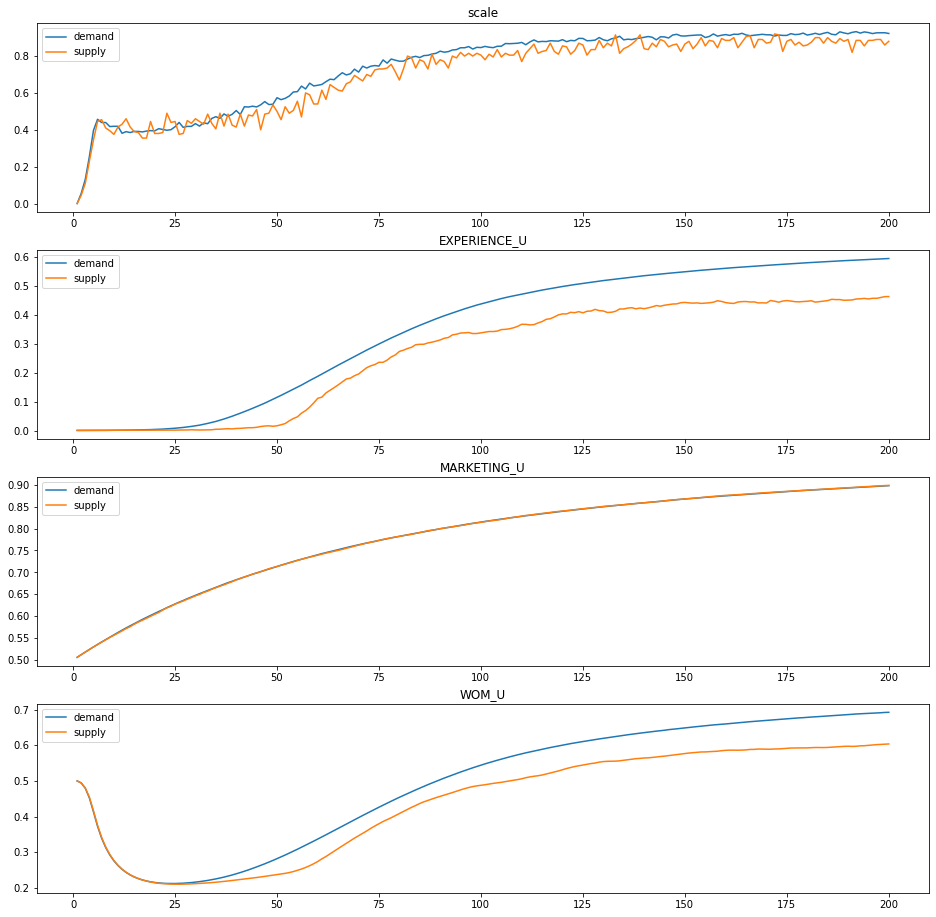

In [10]:
# with S-shaped curve nD=200 nP=2000 nV=200, params.d2d.m=10

lyp = []
lyd = []
sim = sim
for d in range(0,sim.params.nD):
    lyp.append(sim.res[d].pax_exp.OUT.value_counts().get(False, 0)/params.nP)
    lyd.append(sim.res[d].veh_exp.OUT.value_counts().get(False, 0)/params.nV)
lx = [i for i in range(1,len(lyp)+1)]

fig, ax = plt.subplots(nrows=4,figsize=(16,16))
sns.lineplot(x=lx, y=lyp, label = 'demand', ax=ax[0])#, marker='o')
sns.lineplot(x=lx, y=lyd, label = 'supply', ax=ax[0])#, marker='o')
ax[0].set_title('scale')

lyp = []
lyd = []
sim = sim
for d in range(0,sim.params.nD):
    lyp.append(sim.res[d].pax_exp.EXPERIENCE_U.mean())
    lyd.append(sim.res[d].veh_exp.EXPERIENCE_U.mean())
lx = [i for i in range(1,len(lyp)+1)]
sns.lineplot(x=lx, y=lyp, label = 'demand', ax=ax[1])#, marker='o')
sns.lineplot(x=lx, y=lyd, label = 'supply', ax=ax[1])#, marker='o')
ax[1].set_title('EXPERIENCE_U')

lyp = []
lyd = []
sim = sim
for d in range(0,sim.params.nD):
    lyp.append(sim.res[d].pax_exp.MARKETING_U.mean())
    lyd.append(sim.res[d].veh_exp.MARKETING_U.mean())
lx = [i for i in range(1,len(lyp)+1)]
sns.lineplot(x=lx, y=lyp, label = 'demand', ax=ax[2])#, marker='o')
sns.lineplot(x=lx, y=lyd, label = 'supply', ax=ax[2])#, marker='o')
ax[2].set_title('MARKETING_U')

lyp = []
lyd = []
sim = sim
for d in range(0,sim.params.nD):
    lyp.append(sim.res[d].pax_exp.WOM_U.mean())
    lyd.append(sim.res[d].veh_exp.WOM_U.mean())
lx = [i for i in range(1,len(lyp)+1)]
sns.lineplot(x=lx, y=lyp, label = 'demand', ax=ax[3])#, marker='o')
sns.lineplot(x=lx, y=lyd, label = 'supply', ax=ax[3])#, marker='o')
ax[3].set_title('WOM_U')